## Import Packages

In [1]:
from data import shortestpath, dataset
from model import shortestPathModel
from func import blackboxOpt
from evalm import unambSPO

In [2]:
import time
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

## Build Model 

In [3]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-06-13
Using license file C:\Users\Apocrypse\gurobi.lic


## Training

In [4]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [5]:
def train(dataloader, opt_model, num_epochs, learning_rate, lambd=10, l1_lambda=1e-3):
    """
    train model with Black-Box Optimizer
    args:
      dataloader: dataloader from optDataSet
      model: optModel
      num_epochs: number of epochs
      lambda: black-box optimizer parameter
    """
    print('Training...')
    # init model
    lr = LinearRegression()
    # cuda
    if torch.cuda.is_available():
        lr = lr.cuda()
    # training mode
    lr.train()
    # set optimizer
    optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
    # set loss
    criterion = nn.L1Loss()
    # train
    time.sleep(1)
    for epoch in tqdm(range(num_epochs)):
        # load data
        for i, data in enumerate(dataloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # linear regression
            cp = lr(x)
            # black-box optimizer
            wp = blackboxOpt.apply(opt_model, cp, lambd)
            # objective value
            zp = (wp * c).sum(1).view(-1, 1)
            # l1 loss
            loss = criterion(zp, z)
            # l1 reg
            l1_reg = torch.abs(cp - c).sum(dim=1).mean()
            loss += l1_lambda * l1_reg
            # learning rate decay
            cur_lr = learning_rate * 0.6 ** math.floor((epoch / num_epochs) * 10)
            for param_group in optimizer.param_groups:
                param_group['lr'] = cur_lr
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return lr

## Experiments

### Training Set Size = 100, Noise Half−width = 0

In [6]:
# set up
n = 100 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [7]:
# init DataFrame
df1 = pd.DataFrame(columns = degs)

In [8]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2
        num_epochs = 100
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df1 = df1.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 329.68it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 366.14it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.61it/s]


Normalized SPO Loss: 2.06%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 409.27it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 392.14it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


Normalized SPO Loss: 3.88%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 345.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.73it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


Normalized SPO Loss: 9.35%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 338.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.31it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.64it/s]


Normalized SPO Loss: 16.61%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 330.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.30it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


Normalized SPO Loss: 1.66%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 364.06it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.01it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.59it/s]


Normalized SPO Loss: 7.81%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 301.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.91it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


Normalized SPO Loss: 10.11%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 314.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.62it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.70it/s]


Normalized SPO Loss: 29.20%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 374.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.39it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]


Normalized SPO Loss: 1.41%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 393.15it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 408.58it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


Normalized SPO Loss: 3.77%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 384.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.89it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.82it/s]


Normalized SPO Loss: 8.05%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 319.33it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.77it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73it/s]


Normalized SPO Loss: 12.95%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 360.67it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 421.20it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]


Normalized SPO Loss: 1.91%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 379.80it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


Normalized SPO Loss: 6.31%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 283.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.34it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.64it/s]


Normalized SPO Loss: 10.14%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 410.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 395.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.75it/s]


Normalized SPO Loss: 13.21%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 384.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.72it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


Normalized SPO Loss: 1.83%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 348.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.65it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


Normalized SPO Loss: 3.11%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 375.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.83it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


Normalized SPO Loss: 9.40%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 322.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 330.99it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.93it/s]


Normalized SPO Loss: 17.74%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 353.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.58it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s]


Normalized SPO Loss: 2.23%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 379.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


Normalized SPO Loss: 4.62%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 276.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.12it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


Normalized SPO Loss: 12.87%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 453.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 419.57it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


Normalized SPO Loss: 17.14%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 329.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 362.32it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73it/s]


Normalized SPO Loss: 1.58%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 273.90it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.08it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.61it/s]


Normalized SPO Loss: 3.44%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 387.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.63it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]


Normalized SPO Loss: 10.20%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 329.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.04it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]


Normalized SPO Loss: 13.24%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 371.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 390.74it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s]


Normalized SPO Loss: 1.22%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 462.06it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 394.98it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


Normalized SPO Loss: 4.40%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 312.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.47it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.72it/s]


Normalized SPO Loss: 6.94%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 394.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73it/s]


Normalized SPO Loss: 14.42%



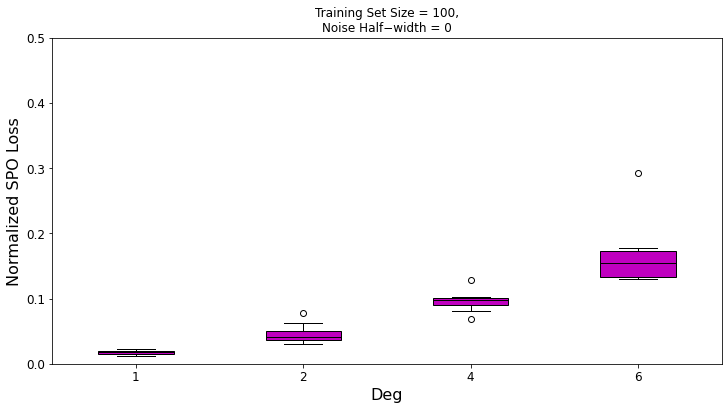

In [9]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df1, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 100, Noise Half−width = 0.5

In [10]:
# set
n = 100 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [11]:
# init DataFrame
df2 = pd.DataFrame(columns = degs)

In [12]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2
        num_epochs = 100
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df2 = df2.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 409.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.70it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


Normalized SPO Loss: 19.47%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 289.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 353.24it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


Normalized SPO Loss: 19.12%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 374.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 368.31it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73it/s]


Normalized SPO Loss: 15.63%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 426.62it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 354.52it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


Normalized SPO Loss: 16.93%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 364.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.70it/s]


Normalized SPO Loss: 21.10%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 313.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.35it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


Normalized SPO Loss: 16.18%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 348.23it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.63it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s]


Normalized SPO Loss: 21.19%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 359.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 375.21it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


Normalized SPO Loss: 51.39%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 343.68it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 382.69it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]


Normalized SPO Loss: 21.35%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 313.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.57it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.54it/s]


Normalized SPO Loss: 20.19%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 343.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 356.08it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.59it/s]


Normalized SPO Loss: 20.12%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 363.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 357.51it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.56it/s]


Normalized SPO Loss: 21.99%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 262.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 271.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Normalized SPO Loss: 21.20%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 279.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 260.54it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


Normalized SPO Loss: 19.44%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 297.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.33it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


Normalized SPO Loss: 20.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 243.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 262.70it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Normalized SPO Loss: 29.38%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 244.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.83it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Normalized SPO Loss: 19.41%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 273.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.48it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


Normalized SPO Loss: 17.85%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 365.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 396.40it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]


Normalized SPO Loss: 18.81%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 361.25it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 400.85it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


Normalized SPO Loss: 12.75%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 406.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 393.74it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]


Normalized SPO Loss: 23.30%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 329.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.09it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.74it/s]


Normalized SPO Loss: 18.25%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 397.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 421.62it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.43it/s]


Normalized SPO Loss: 23.30%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 397.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


Normalized SPO Loss: 19.47%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 308.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.53it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


Normalized SPO Loss: 20.28%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 319.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.65it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.70it/s]


Normalized SPO Loss: 17.65%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 333.07it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.83it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.47it/s]


Normalized SPO Loss: 17.94%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 305.69it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 282.18it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.62it/s]


Normalized SPO Loss: 38.33%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 351.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.33it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


Normalized SPO Loss: 21.05%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 331.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 358.39it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]


Normalized SPO Loss: 15.74%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 433.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 346.25it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]


Normalized SPO Loss: 20.35%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 315.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


Normalized SPO Loss: 29.65%



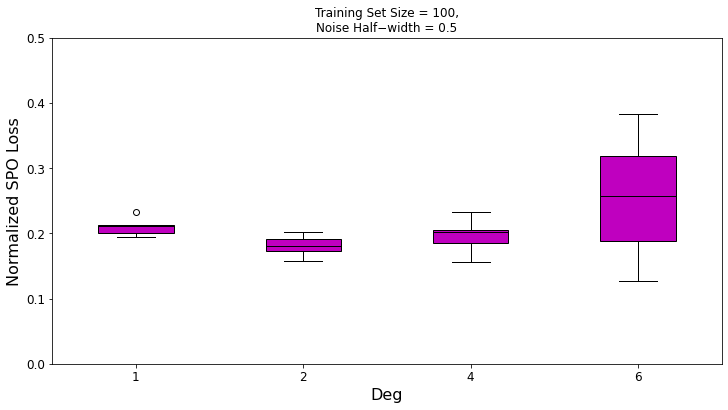

In [13]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df2, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0.5')
plt.show()

### Training Set Size = 1000, Noise Half−width = 0 

In [14]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [15]:
# init DataFrame
df3 = pd.DataFrame(columns = degs)

In [16]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2
        num_epochs = 30
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df3 = df3.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.80it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.48it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:08<00:00,  6.29s/it]


Normalized SPO Loss: 0.76%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 358.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 396.09it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:58<00:00,  5.93s/it]


Normalized SPO Loss: 3.62%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 385.33it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 404.24it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:57<00:00,  5.91s/it]


Normalized SPO Loss: 8.60%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.15it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.13it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:53<00:00,  5.78s/it]


Normalized SPO Loss: 10.85%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 261.99it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:00<00:00,  6.01s/it]


Normalized SPO Loss: 0.27%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 385.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 376.79it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:59<00:00,  5.98s/it]


Normalized SPO Loss: 4.09%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 399.17it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 352.11it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:50<00:00,  5.68s/it]


Normalized SPO Loss: 6.36%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.70it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.22it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:54<00:00,  5.81s/it]


Normalized SPO Loss: 20.32%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.40it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 384.73it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:51<00:00,  5.72s/it]


Normalized SPO Loss: 0.62%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 366.62it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:51<00:00,  5.73s/it]


Normalized SPO Loss: 2.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 395.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.32it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:58<00:00,  5.94s/it]


Normalized SPO Loss: 5.45%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 251.66it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:50<00:00,  5.70s/it]


Normalized SPO Loss: 10.59%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.81it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:53<00:00,  5.79s/it]


Normalized SPO Loss: 0.76%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 376.06it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 358.61it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:57<00:00,  5.91s/it]


Normalized SPO Loss: 2.72%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 388.61it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:52<00:00,  5.74s/it]


Normalized SPO Loss: 8.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.02it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:54<00:00,  5.82s/it]


Normalized SPO Loss: 13.87%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.56it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:49<00:00,  5.65s/it]


Normalized SPO Loss: 0.24%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.26it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:52<00:00,  5.74s/it]


Normalized SPO Loss: 3.82%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 393.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.88it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:56<00:00,  5.90s/it]


Normalized SPO Loss: 8.59%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 362.16it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 390.46it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:56<00:00,  5.89s/it]


Normalized SPO Loss: 17.04%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 262.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 255.16it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:45<00:00,  5.51s/it]


Normalized SPO Loss: 1.05%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 379.74it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:27<00:00,  4.93s/it]


Normalized SPO Loss: 3.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 423.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 412.81it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.88s/it]


Normalized SPO Loss: 6.22%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 447.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 434.14it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:23<00:00,  4.80s/it]


Normalized SPO Loss: 17.26%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 450.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 455.98it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:19<00:00,  4.66s/it]


Normalized SPO Loss: 0.21%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 411.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 362.50it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.74s/it]


Normalized SPO Loss: 3.21%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 449.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 463.34it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.81s/it]


Normalized SPO Loss: 8.11%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.83it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:42<00:00,  5.41s/it]


Normalized SPO Loss: 17.75%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 400.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 401.48it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:31<00:00,  5.06s/it]


Normalized SPO Loss: 0.17%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 420.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 392.85it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:43<00:00,  5.45s/it]


Normalized SPO Loss: 3.57%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:33<00:00,  5.11s/it]


Normalized SPO Loss: 6.59%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.84it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:33<00:00,  5.13s/it]


Normalized SPO Loss: 10.86%



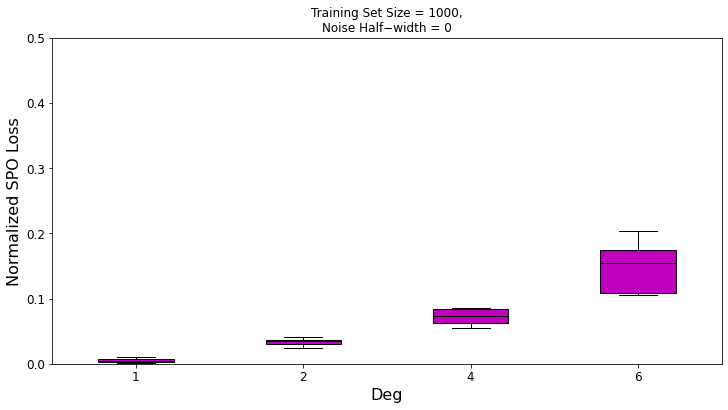

In [17]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df3, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 1000, Noise Half−width = 0.5 

In [18]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [19]:
# init DataFrame
df4 = pd.DataFrame(columns = degs)

In [20]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2
        num_epochs = 30
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df4 = df4.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 406.73it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 411.97it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:47<00:00,  5.60s/it]


Normalized SPO Loss: 20.28%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.89it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:46<00:00,  5.53s/it]


Normalized SPO Loss: 16.82%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 399.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 413.21it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:35<00:00,  5.19s/it]


Normalized SPO Loss: 14.74%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 402.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.80it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:37<00:00,  5.27s/it]


Normalized SPO Loss: 26.92%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 401.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 401.84it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:32<00:00,  5.08s/it]


Normalized SPO Loss: 22.88%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.00it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.28it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:44<00:00,  5.47s/it]


Normalized SPO Loss: 14.76%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 386.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 419.59it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:32<00:00,  5.08s/it]


Normalized SPO Loss: 17.37%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 436.33it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 413.66it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:28<00:00,  4.95s/it]


Normalized SPO Loss: 31.87%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 393.38it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:10<00:00,  6.35s/it]


Normalized SPO Loss: 21.76%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 389.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 397.53it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:44<00:00,  5.47s/it]


Normalized SPO Loss: 21.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 409.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 420.13it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:45<00:00,  5.53s/it]


Normalized SPO Loss: 18.76%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 432.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 422.16it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.81s/it]


Normalized SPO Loss: 22.52%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 404.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.87s/it]


Normalized SPO Loss: 21.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 440.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 451.11it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.88s/it]


Normalized SPO Loss: 18.83%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 368.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.92it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.75s/it]


Normalized SPO Loss: 23.36%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 429.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 437.90it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.82s/it]


Normalized SPO Loss: 18.91%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 443.42it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 455.72it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.73s/it]


Normalized SPO Loss: 22.68%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 364.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 356.60it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.75s/it]


Normalized SPO Loss: 17.46%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 461.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 467.38it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:25<00:00,  4.86s/it]


Normalized SPO Loss: 17.80%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 434.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 435.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:25<00:00,  4.84s/it]


Normalized SPO Loss: 29.17%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 403.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 433.20it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.76s/it]


Normalized SPO Loss: 22.84%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 438.88it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 447.90it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.83s/it]


Normalized SPO Loss: 18.00%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 455.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 434.14it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:34<00:00,  5.14s/it]


Normalized SPO Loss: 17.64%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.18it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 397.84it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.82s/it]


Normalized SPO Loss: 21.04%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 413.98it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.88s/it]


Normalized SPO Loss: 22.28%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 431.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 419.96it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.88s/it]


Normalized SPO Loss: 16.15%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 443.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 444.34it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.81s/it]


Normalized SPO Loss: 17.42%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 426.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 448.15it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.76s/it]


Normalized SPO Loss: 32.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 448.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 378.64it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:29<00:00,  4.98s/it]


Normalized SPO Loss: 22.25%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 448.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 439.31it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.87s/it]


Normalized SPO Loss: 19.04%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 439.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 434.16it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:33<00:00,  5.11s/it]


Normalized SPO Loss: 18.88%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 427.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 431.58it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.83s/it]


Normalized SPO Loss: 30.92%



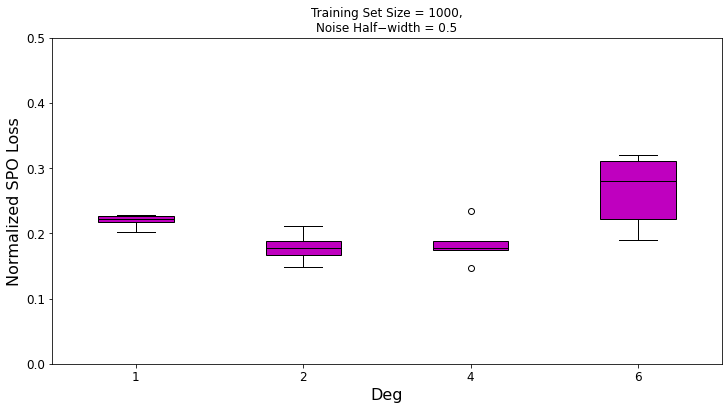

In [21]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df4, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0.5')
plt.show()

## Save File 

In [22]:
df1.to_csv('./res/blackbox_n100.csv', index=False)
df2.to_csv('./res/blackbox_n100_noise.csv', index=False)
df3.to_csv('./res/blackbox_n1000.csv', index=False)
df4.to_csv('./res/blackbox_n1000_noise.csv', index=False)